<a href="https://colab.research.google.com/github/tinaghimire/data-mining/blob/main/Lab-6_KMeans/Kmeans_lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm

In [4]:
image_path = 'Lake.jpg'
image = cv2.imread(image_path)
image.shape

(494, 480, 3)

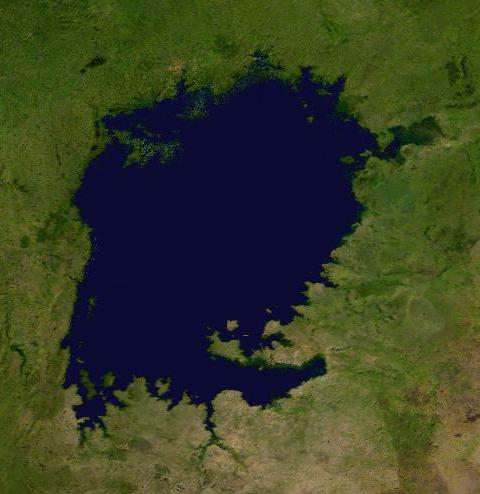

In [5]:
cv2_imshow(image)

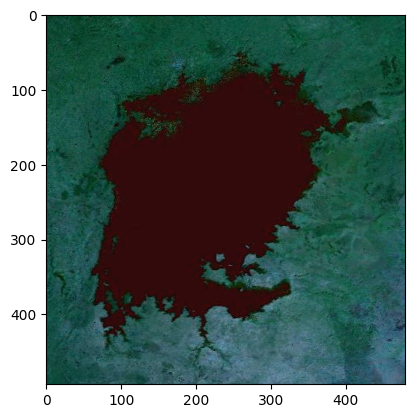

In [6]:
plt.imshow(image)

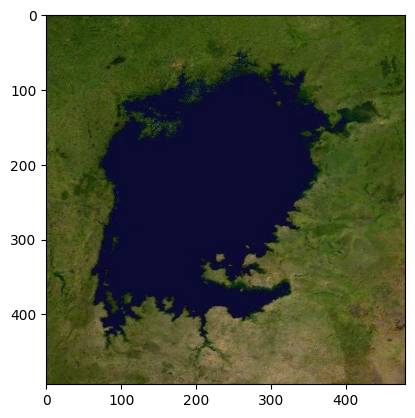

In [7]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

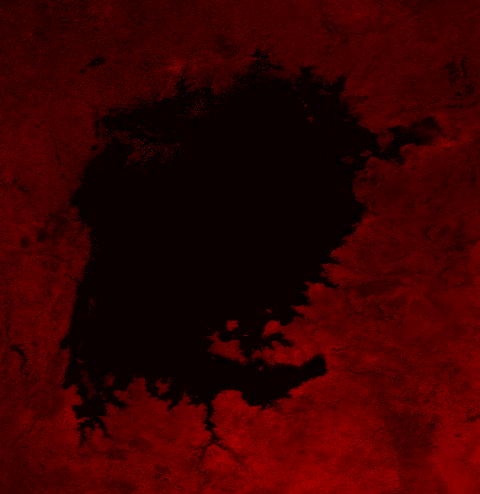

In [8]:
red_image = image.copy()
red_image[:,:,0] = 0 # B
red_image[:,:,1] = 0 # G

cv2_imshow(red_image)

In [9]:
pixels = image.reshape(-1,3)
pixels.shape

(237120, 3)

In [10]:
from sklearn.cluster import KMeans

num_clusters = 3

pixels = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels = pixels.reshape(-1,3)

kmeans = KMeans(n_clusters = num_clusters, random_state= 42)
kmeans.fit(pixels)
y_kmeans = kmeans.predict(pixels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[ 11.64636024,  13.0002458 ,  45.76616774],
       [107.44976155, 103.57321987,  56.75491284],
       [ 64.64145071,  79.63563995,  22.98036394]])

In [12]:
import numpy as np
roudoff = np.rint(cluster_centers)
roudoff

array([[ 12.,  13.,  46.],
       [107., 104.,  57.],
       [ 65.,  80.,  23.]])

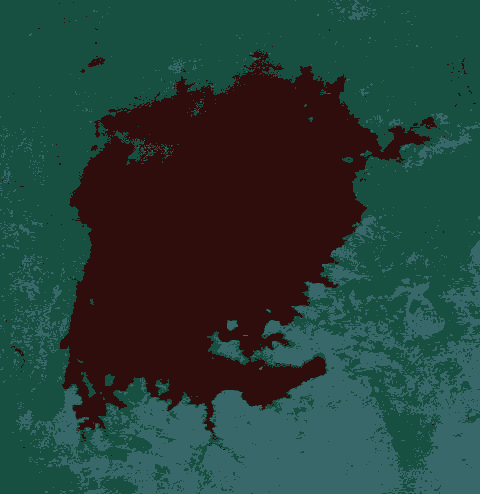

In [13]:
import numpy as np
clustered_image = roudoff[kmeans.labels_].astype(np.uint8).reshape(image.shape)
cv2_imshow(clustered_image)

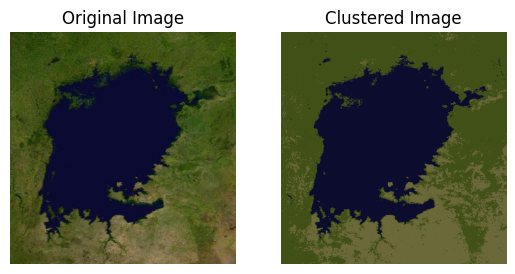

In [14]:
plt.subplot(1, 2, 1)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.title('Original Image')
plt.imshow(image_rgb)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Clustered Image')
plt.imshow(clustered_image)

In [15]:
from skimage.metrics import mean_squared_error as mse

mse(image_rgb, clustered_image)

118.71107174988754

In [16]:
def mean_squared_error_fn(image0, image1):
    image0 = image0.astype(np.float64)
    image1 = image1.astype(np.float64)
    sums = 0
    for i in range(image0.shape[0]):
        for j in range(image0.shape[1]):
            for k in range(image0.shape[2]):
                sums += (image0[i, j, k] - image1[i, j, k]) ** 2
    return sums / (image0.shape[0] * image0.shape[1] * image0.shape[2])

mean_squared_error_fn(image_rgb, clustered_image)

118.71107174988754

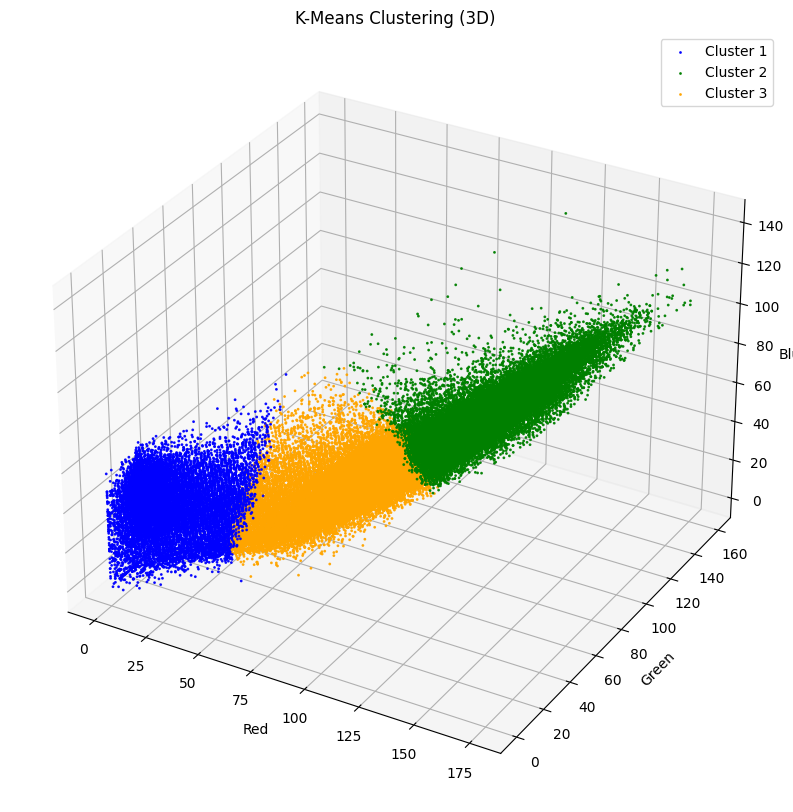

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = ['blue', 'green', 'orange', 'purple']

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(cluster_centers)):
    ax.scatter(pixels[y_kmeans == i, 0], pixels[y_kmeans == i, 1], pixels[y_kmeans == i, 2],
               color=colors[i],
               s=1,
               alpha=0.9,
               label=f'Cluster {i+1}')

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('K-Means Clustering (3D)')
ax.legend()
plt.show()

In [18]:
cluster_sizes = np.bincount(kmeans.labels_, minlength = num_clusters)
total_pixels = kmeans.labels_.size
percentage_pixels = (cluster_sizes /total_pixels)*100

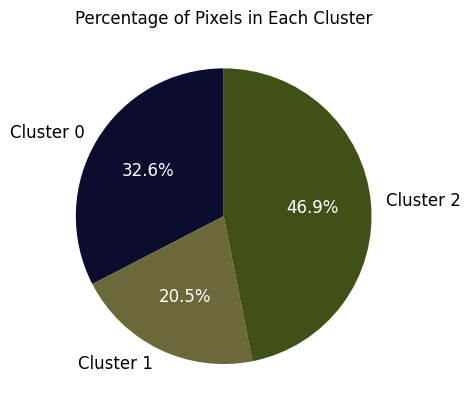

In [19]:
def RGB(cluster_centers):
    return np.array(cluster_centers / 255)


fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    percentage_pixels,
    colors=RGB(cluster_centers),
    labels=[f"Cluster {i}" for i in range(num_clusters)],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12}
)

for i, autotext in enumerate(autotexts):
    autotext.set_color("White")  # Set text color to match cluster centroid color

ax.set_title('Percentage of Pixels in Each Cluster')
plt.show()


In [20]:
cluster_data ={
    'Cluster':range(num_clusters),
    'Pixel_Count' : cluster_sizes,
    'Red':cluster_centers[:,0],
    'Blue':cluster_centers[:,1],
    'Green':cluster_centers[:,2]
}
cluster_dataframe = pd.DataFrame(cluster_data)

cluster_dataframe.set_index('Cluster', inplace = True)
cluster_dataframe

,Pixel_Count,Red,Blue,Green
Cluster,,,,
0,77293,11.646360,13.000246,45.766168
1,48672,107.449762,103.573220,56.754913
2,111155,64.641451,79.635640,22.980364


In [21]:
pixel_sum = sum(cluster_dataframe['Pixel_Count'])
pixel_sum

237120

In [22]:
# Suppose the area of the lake is approx. 200000 sq km.
total_area = 200000
cluster_dataframe['Area'] = (cluster_dataframe['Pixel_Count'] / pixel_sum) * total_area
cluster_dataframe

,Pixel_Count,Red,Blue,Green,Area
Cluster,,,,,
0,77293,11.646360,13.000246,45.766168,65193.151147
1,48672,107.449762,103.573220,56.754913,41052.631579
2,111155,64.641451,79.635640,22.980364,93754.217274


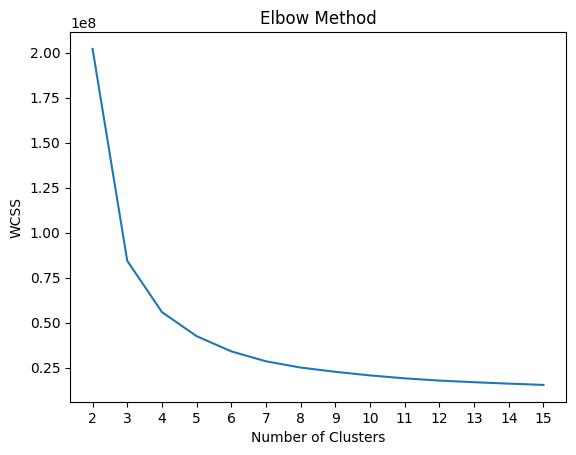

In [23]:
wcss = []
for k in range(2,16):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pixels)
    wcss.append(kmeans.inertia_)

plt.plot(range(2,16), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.xticks(range(2,16))
plt.show()

Here, optimal value is 3. The WCSS shows a significant decrease up to this point, and the rate of decrease diminishes afterward.

In [24]:
n_clusters = range(3,5)
for num_clusters in n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)

    silhouette_avg = silhouette_score(pixels, labels)
    print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg}")

    silhouette_values = silhouette_samples(pixels, labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for 3 clusters: 0.6462705117739319


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for 4 clusters: 0.5720651805335869


In [25]:
type(silhouette_values)

numpy.ndarray

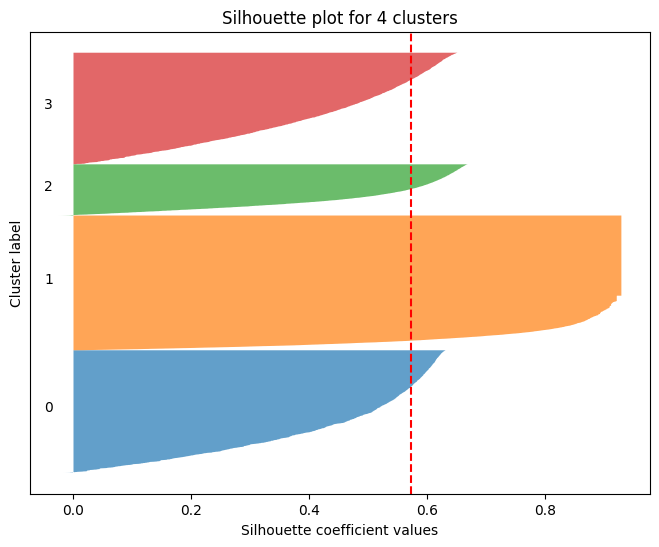

In [26]:
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(num_clusters):
    cluster_silhouette_values = silhouette_values[labels == i]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

    y_lower = y_upper + 10

plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title(f"Silhouette plot for {num_clusters} clusters")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([])
plt.show()

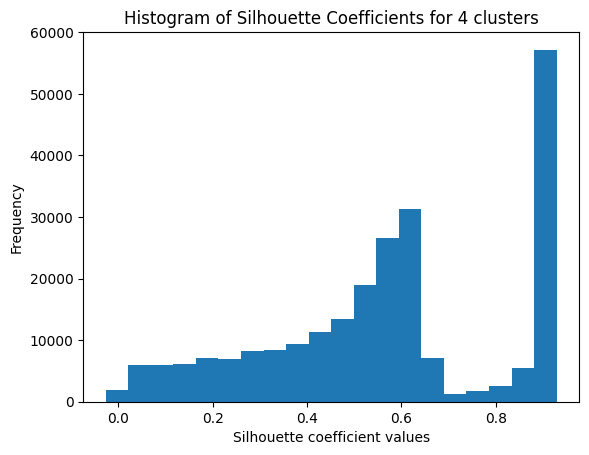

In [27]:
plt.hist(silhouette_values, bins=20)
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Frequency")
plt.title(f"Histogram of Silhouette Coefficients for {num_clusters} clusters")
plt.show()